## Jac Royston Rees: 961103
## Optimisation Coursework: Developing Optimisers Within Python

**1. Which stochastic optimiser did you choose?**  
Simulated Annealing was selected, which uses *temperature* *(tk)* to control the degree of stochasticity during randomized search. Initially, the temperature is high, allowing the process to freely move about the feasible space, with the hope that the process will find an adaquete region with good local minima. The temperature is then gradually decreased by annealing with one of many decay schemes such as: $$\gamma t_k$$ where gamma is pre-set value (initialised between *0.25, 0.5 and 0.75*). As the *temperature* is decreased, the stochasticity of the algorithm correlates with the temperatures decrease, forcing the search to converge to a minmum.  
**2. Why did you choose this optimiser?**  
This optimiser was chosen due to its ability to escape local minima, through using its *temperature* scheme to dictate *acceptance probabilities*, something which is extremely beneficial to a problem with a solution which requires 3 dimensional input.
By defining a local-search transition distribution (*multi-variate normal distribution*) and searching between the bounds with a pre-set variance of:
$$(upperbound_i - lowerbound_i) \bullet percentsearch$$
centred about the mean-x value(xc), which is calculated according to decay-scheduling. The algorithm can then maximise both *exploration* and *exploitation*, giving a much greater chance of finding the global optima.  
**3. What constraint handling method(s) are you using and why?**
For Random Search, *rejection sampling* was used, due to random searches entirely stochastic approach to solving a problem. Rejection sampling works by using random sampling from the distribution (*lower and upper bounds*) for each dimension. 

In [1]:
##import required packages
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import itertools
import math
from scipy.stats import truncnorm
import random
import scipy
np.set_printoptions(suppress=True) #Suppress scientific notation

In [2]:
minimized_items= np.array(['Diameter of The wire', 'Mean Diameter Of Coil', 'Number of Active Coils']) #define the 3 dimensions

In [3]:
##Set the seed
np.random.seed(3)

## Feasible Space Criteria:



In [4]:
f_count = 0
g1_count = 0
g2_count = 0 #Create a counter for each constraint as-well as the number of times f_count has been called
g3_count = 0
g4_count = 0

In [5]:
def f(x):
    global f_count #reference the global variable
    f_count += 1 #increment the counter by 1
    x1, x2, x3 = x #obtain x1,x2,x3 from the vector x
    res = np.multiply(np.multiply(x1**2,x2),2+x3)
    return res #return result

In [6]:
def g1(x):
    global g1_count #reference the global variable
    g1_count += 1 #increment counter by 1
    x1,x2,x3 = x #obtain x1,x2,x3 from the vector x
    res =  1 - np.divide(np.multiply(x2**3,x3), np.multiply(71785,x1**4)) 
    return res #return the result of the calculation

In [7]:
def g2(x):
    global g2_count #reference the global variable
    g2_count += 1 #increment counter by 1
    x1,x2,x3 = x #obtain x1,x2,x3 from the vector x
    component1 = np.divide(np.multiply(4, np.power(x2, 2)) - np.multiply(x1, x2), np.multiply(12566,(np.multiply(x2, np.power(x1, 3))-1))) #compute the first component
    component2 = np.divide(1, np.multiply(51208, np.power(x1, 2))) #compute the second component
    res= (component1 + component2) - 1
    return res#return the result of the calculation
    
    

In [8]:
def g3(x): 
    global g3_count #reference the global variable
    
    g3_count += 1 #increment by one
    x1,x2,x3 = x # obtain x1,x2,x3 from the vector x
    res = (1- np.divide(np.multiply(140.45, x1), np.multiply(np.power(x2,2),x3)))
    return res

In [9]:
def g4(x):
    global g4_count #reference the global variable
    g4_count +=1 #increment counter by 1
    x1,x2,x3 = x # obtain x1,x2,x3 from the vector x
    res = (np.divide(x1+x2, 1.5) - 1)
    return res

## Adaptive Penalty

In [10]:
p = 0
lambda_t = 0

In [11]:
def adaptive(x, f, constraints,  beta1, beta2):
    global p
    global lambda_t
    if(p >= 5):
        #print('case 1')
        lambda_t = np.multiply(np.divide(1, beta1), lambda_t)
    if(p <= -2):
        #print('case 2')
        lambda_t = np.multiply(beta2, lambda_t)
    else:
        #print('case 3')
        lambda_t = lambda_t
        
    #print(p)
    return np.multiply(lambda_t, np.max([0, constraints(x)]))**2

In [12]:
def phi_adaptive(x, f, constraints, beta1, beta2 ):
    return np.add(f(x), adaptive(x, f, constraints, beta1, beta2))

## Create constraints subject to: $\bar{g}(x)=max_{g_i}g_i(x) \leq 0$

In [13]:
def constraints(x): 
    x1,x2,x3 = x #obtain x1,x2,x3 from the vector x
    return max(g1(x), g2(x),g3(x), g4(x)) #Returns true or false depending on whether all results return values below the specified inequality constraints

In [14]:
def bounds(x):

#Check whether each scalar within the vector satisfies corresponding bounds
    x1,x2,x3 = x
    if(x1 >= 0.05 and x1 <= 2):
        if(x2 <= 1.3 and x2 >= 0.25):
            if(x3 <= 15 and x3 >= 2):
                return True
    return False

## Random Search And Simulated Annealing Algorithms:

In [15]:
def random_search(function, constraints, max_iter, lower_bound, 
                  upper_bound):
    """
    Random Search Algorithm. 
    
    parameters. 
    fucntion: The function to optimize
    k_vector: The constraints to abide by
    lower_bound: The 3 dimensional lower-bound vector
    uppwer_bound: The 3 dimensional upper-bound vector
    fargs: non-keyword arguments for the function
    
    returns best solution found and its function value. (best_x and best_y)
    """
   
    
    results = np.array([]) #create an empty array for the y values
    points = [] #create an empty array for the x vectors
   # print(points.shape)
    k = 0
    while k <max_iter: #iterate until it has performed 3000 valid iterations       
        point = np.random.uniform(low=lower_bound, high=upper_bound, size=len(lower_bound)) #obtain a random uniform vector of points within the bounds
        
        #print(point)
        if((constraints(point) <= 0) and bounds(point)): #check to see if it satisfies the constraints AND bounds
            results = np.append(results, np.float64(function(point))) #add the function result(y) to the results array
            points.append(point) #add the points vector to a list
            k += 1 #since it is a feasible solution, increment the k value
    
   
    best_ind = np.argmin(results) #get the index with the smallest y value
    #print(points.shape)
    return points[best_ind], results[best_ind]

    

In [55]:
def simulated_annealing(function, constraints, tk,k_max, lower_bound, upper_bound, gamma, search_percent,  fargs=()):
    
    """
    Simulated Annealing Algorithm. 
    
    parameters. 
    function: The function to optimize
    k_vector: The constraints to abide by
    tk = the initial temperature and thus the temperature after each iteration
    k_max = The number of function evaluations
    lower_bound: The 3 dimensional lower-bound vector
    upper_bound: The 3 dimensional upper-bound vector
    gamma: The decay rate
    search_percent: the variance to search the normal-distribution
    fargs: non-keyword arguments for the function
    
    returns best solution found and its function value. (best_x and best_y)
    """
    np.seterr(all='ignore') 
    
    k = 0 #initialise the variable k to zero
    global lambda_t
    global p
    p = 0
    lambda_t = 10
   
    satisfies = False #initialise the boolean to false to repeat searching for a random vector which satisfies the bounds and feasible space criteria
    results = np.array([]) #create an empty array of results
    sigma = (upper_bound - lower_bound) * search_percent #create a sigma vector of each area to search
    
    cov = ([[sigma[0], 0, 0], #create a 2D array for the Covariance Diagnol matrix using the values within the sigma vector
            [0, sigma[1], 0], 
            [0, 0, sigma[2]]])
    
 
    while(not satisfies):
        x_best = np.random.uniform(low = lower_bound, high = upper_bound, size = len(lower_bound)) #obtain a random uniform vector of points within the bounds
        
        if(bounds(x_best)): #check if the initial x_best satisfies the constraints and bounds
           
            satisfies = True # if it does; set the boolean to true to continue the algorithm
            p+=1
        else:
            p-=1
            
    

    y_best =  np.float64(function(x_best,  *fargs)) #obtain the new y_best
    xc, yc = x_best, y_best # center the search at xc,yc
    
    while(k < (k_max-1)): #minus 1 due to it already being called once previously
        
       
        x_prime = np.random.multivariate_normal(xc, cov) #obtain a new random vector for x_prime using a multivariate-normal distribution
        
        if(bounds(x_prime)): #check to see if it satisfies the constraints
            if(p <= 0):
                p = 1
            else:
                p += 1
            y_prime = np.float64(function(x_prime,*fargs)) #calculate the new y_prime from x_prime and corresponding function
            results = np.append(results, yc) #append the centered value (this is solely for testing and initial decrease)
            delta_y = y_prime - yc #take the centered y from the new y_prime


            #If statement to check whether we are assigning new xc and yc values
            if((delta_y <= 0) or ((np.random.uniform(low = 0, high = 1) < min(np.exp(np.true_divide(-delta_y, tk )), 1)))): 
                xc, yc = x_prime, y_prime

                    #If statement to see if we have obtained a new best minimised value
            if((y_prime < y_best)): 
                x_best, y_best = x_prime, y_prime
        else:
            if(p >= 0):
                p = -1
            else:
                p -= 1

            tk =  np.float64(gamma * tk) #decay the value of tk
            k+=1 #since everything is satisfied and accounted for we can now increment the value i for the while loop
            
        
    return x_best, y_best

## Initiate variables for each algorithm

In [56]:
tk = 10 # initial temperate
gamma = 0.25 #decay value
search_percent = 0.15
number_of_samples = 3000 #number of times which we can run feasible solutions
lower_bound = np.array([0.05, 0.25,2])
upper_bound = np.array([2, 1.3, 15])
beta1 = 2
beta2 = 1.5

## Run one iteration of each to determine optimum

In [57]:
x_best_rand, y_best_rand = random_search(f,constraints, number_of_samples, lower_bound, upper_bound)
#x_best_sim, y_best_sim = sim_anneal(f, constraints, tk,number_of_samples, lower_bound, upper_bound, gamma, search_percent)


In [58]:

x_best_sim, y_best_sim = simulated_annealing(phi_adaptive, constraints, tk,number_of_samples, lower_bound, upper_bound, gamma, search_percent, fargs=(f, constraints, beta1, beta2))

## Print the F-Count To Illustrate number of times the function has been called:

In [59]:
print('The Counter \'F Count\' has been called: ', f_count, ' times between the two algorithms')

The Counter 'F Count' has been called:  274499  times between the two algorithms


## Best Random Search Solution From One Run:

In [60]:
print(x_best_rand)
print("The Best Solution For Random Search:")
print("x1({}) with a value of: {}".format(minimized_items[0],x_best_rand[0]))
print("x2({}) with a value of: {}".format(minimized_items[1],x_best_rand[1]))
print("x3({}) with a value of: {}".format(minimized_items[2],x_best_rand[2]))
print("Minimized function with a value of: {}".format(y_best_rand))

[0.05090453 0.5660156  2.94052473]
The Best Solution For Random Search:
x1(Diameter of The wire) with a value of: 0.050904529406810055
x2(Mean Diameter Of Coil) with a value of: 0.5660156003897916
x3(Number of Active Coils) with a value of: 2.9405247274394526
Minimized function with a value of: 0.007246267002325559


## Best Simulated Annealing Solution From One Run:

In [61]:

print("The Best Solution For Simulated Annealing:")
print("x1({}) with a value of: {}".format(minimized_items[0],x_best_sim[0]))
print("x2({}) with a value of: {}".format(minimized_items[1],x_best_sim[1]))
print("x3({}) with a value of: {}".format(minimized_items[2],x_best_sim[2]))
print("Minimized function with a value of: {}".format(y_best_sim))

The Best Solution For Simulated Annealing:
x1(Diameter of The wire) with a value of: 0.05178678775079249
x2(Mean Diameter Of Coil) with a value of: 0.3402603268942213
x3(Number of Active Coils) with a value of: 3.682550937340146
Minimized function with a value of: 0.005185535442335574


## Run each Algorithm 21 Times to Determine The Best Solution For Each:

In [54]:

n_repeats = 21 #Amount of times to run the experiments

res_random_x = [] #Empty Array of the appropriate size
res_random_y = np.array([]) #Empty list for the minimized values
res_simulated_x = []
res_simulated_y = np.array([])
for j in range(n_repeats):
    sim_i_x, sim_i_y = simulated_annealing(phi_adaptive, constraints, tk,number_of_samples, lower_bound, upper_bound, gamma, search_percent, fargs=(f, constraints, beta1, beta2))
    res_simulated_x.append(sim_i_x)
    res_simulated_y = np.append(res_simulated_y, sim_i_y)


for i in range(n_repeats): #Repeat the experiment 
    rand_i_x, rand_i_y = random_search(f, constraints, number_of_samples, lower_bound, upper_bound)
    res_random_x.append(rand_i_x) #Append the best x values to the array
    res_random_y = np.append(res_random_y, rand_i_y) #append the best y values to the array



In [45]:
#res_simulated_x = res_simulated_x[0:21, :] #Decrease size of the Simaneal experiment to the first 21 instances
#res_random_x = res_random_x[0:21, :] #Decrease size of the random experiment to the first 21 instances
np.set_printoptions(suppress=True) #Display the values NOT in scientific notation(e.g. 1.233e-39)
res_simulated_x = np.array(res_simulated_x) #convert list to matrix
res_random_x = np.array(res_random_x) #convert list to matrix


In [46]:
#res_random_x = np.append(res_random_x, x_best_rand)
#res_random_y = np.append(res_random_y, y_best_rand)

#res_simulated_x = np.append(res_simulated_x, x_best_sim)
#res_simulated_y = np.append(res_simulated_y, y_best_sim)

rand_index = np.argmin(res_random_y)
x_best_rand_index = res_random_x[rand_index]
y_best_rand_index = res_random_y[rand_index]

sim_index = np.argmin(res_simulated_y)
x_best_sim_index = res_simulated_x[sim_index]
y_best_sim_index = res_simulated_y[sim_index]

## Best Random Search Solution After 21 Searches

In [48]:
print("The Best Solution For Random Search:")
print("x1({}) with a value of: {}".format(minimized_items[0],x_best_rand_index[0]))
print("x2({}) with a value of: {}".format(minimized_items[1],x_best_rand_index[1]))
print("x3({}) with a value of: {}".format(minimized_items[2],x_best_rand_index[2]))
print("Minimized function with a value of: {}".format(y_best_rand_index))

The Best Solution For Random Search:
x1(Diameter of The wire) with a value of: 0.050431474888318
x2(Mean Diameter Of Coil) with a value of: 0.6071595798939348
x3(Number of Active Coils) with a value of: 2.1677950630934184
Minimized function with a value of: 0.006435948297773621


## Best Simulated Annealing Solution After 21 Searches

In [49]:
print("The Best Solution For Simulated Annealing: ")
print("x1({}) with a value of: {}".format(minimized_items[0],x_best_sim_index[0]))
print("x2({}) with a value of: {}".format(minimized_items[1],x_best_sim_index[1]))
print("x3({}) with a value of: {}".format(minimized_items[2],x_best_sim_index[2]))
print("Minimized function with a value of: {}".format(y_best_sim_index))

The Best Solution For Simulated Annealing: 
x1(Diameter of The wire) with a value of: 0.050625096691269154
x2(Mean Diameter Of Coil) with a value of: 0.2937675993131714
x3(Number of Active Coils) with a value of: 2.1920533238026803
Minimized function with a value of: 0.0031561847997311813


## Plot 3-Dimensional with Colormap as Minimized Value

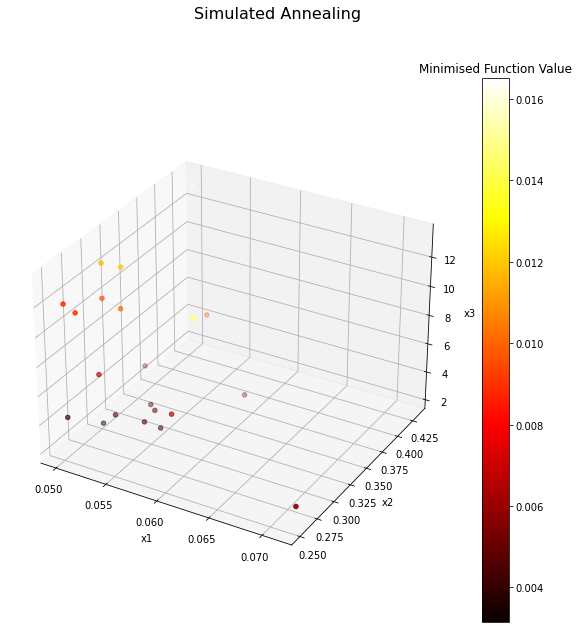

In [50]:

fig = plt.figure(figsize=(10,10)) #plot a figure of size...
fig.suptitle('Simulated Annealing', fontsize=16) #set title
ax = fig.add_subplot(111, projection='3d') #project it onto a 3-dimensional plane

#get each dimension value
x1 = res_simulated_x[:,0] 
x2 = res_simulated_x[:,1] 
x3 = res_simulated_x[:,2]
y = res_simulated_y
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
img = ax.scatter(x1, x2, x3, c = y, cmap = plt.hot())
clb = plt.colorbar(img) #use color as fourth/minimized dimension
clb.ax.set_title('Minimised Function Value')
plt.show()

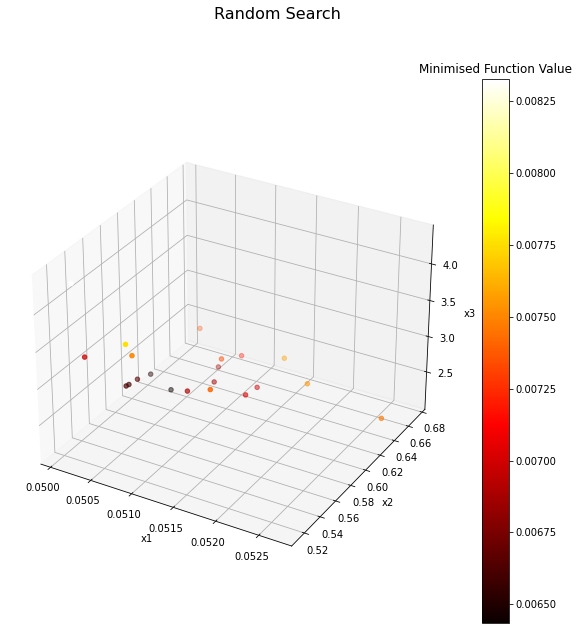

In [51]:
fig = plt.figure(figsize=(10,10)) #plot figure of size..
ax = fig.add_subplot(111, projection='3d') #Project onto 3-Dimensional plane
fig.suptitle('Random Search', fontsize=16)
#get each dimension value
x1 = res_random_x[:,0]
x2 = res_random_x[:,1]
x3 = res_random_x[:,2]
y = res_random_y
best_y = np.argmin(res_random_y)
best_x = res_random_x[best_y]


#set the labels
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')

img = ax.scatter(x1, x2, x3, c = y, cmap = plt.hot())
clb = plt.colorbar(img)
clb.ax.set_title('Minimised Function Value') #set fourth dimension title

plt.show()

## Plot Comparisons Between The Two Algorithms

Text(0, 0.5, 'Best Objective Value')

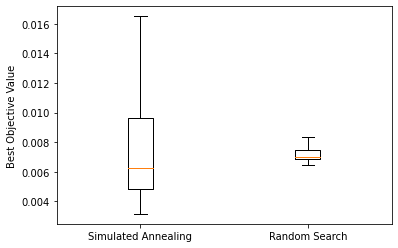

In [52]:
#Using a boxplot compare the 
plt.boxplot([res_simulated_y, res_random_y])
plt.xticks([1,2], ['Simulated Annealing', 'Random Search'])
plt.ylabel("Best Objective Value")